# Visualizing RST and layout structures in GeM corpora

This Jupyter notebook is intended for visualizing discourse structures in multimodal documents, as described using <a href="http://www.sfu.ca/rst/">Rhetorical Structure Theory</a> and annotated using the schema provided by the <a href="http://www.fb10.uni-bremen.de/anglistik/langpro/projects/gem/newframe.html">Genre and Multimodality</a> model.

For visualizing the RST and layout structures, you need valid XML files for base, RST and layout layers. The content is retrieved from the base layer, before drawing out the rhetorical relations between the content and organizing it into the hierarchy defined in the layout structure.

The notebook adopts the technique proposed in Thomas (2009) for representing RST structures using Graphviz DOT, originally implemented in Perl and rewritten in XQuery as a part of Hiippala (2013). The RST relations ("spans") are represented using DOT nodes. Relations are drawn as edges from both nuclei and satellite nodes ("segments") towards the span, thus creating a hierarchical structure suitable for representing RST structures. The nodes are organized into DOT subgraphs according to their hierarchical organization as represented using the GeM layout structure.

**References**

Hiippala, T. (2013) *Modelling the structure of a multimodal artefact*. PhD thesis, University of
Helsinki. https://helda.helsinki.fi/handle/10138/41736

Thomas, M. (2009) *Localizing pack messages: A framework for corpus-based cross-cultural
multimodal analysis*. PhD thesis, University of Leeds.

## 1. Import the necessary packages.

In [1]:
# For parsing XML
from lxml import etree as et

# For formatting the content
import textwrap
import codecs

# For testing
from IPython.display import Image

Check GraphViz installation.

In [2]:
graphviz_installed = !which dot
if graphviz_installed == '':
    print "Graphviz/DOT not found. Exiting ..."
    quit()
else:
    print "Graphviz/DOT found ..."

Graphviz/DOT found ...


## 2. Parse the GeM XML files.

Define the base and RST files below.

In [3]:
basefile = 'test_xml/1980-tgh-base-1.xml' # Base layer
rstfile = 'test_xml/1980-tgh-rst-1.xml' # RST layer
layoutfile = 'test_xml/1980-tgh-layout-1.xml' # Layout layer

Define a function to parse the XML files.

In [4]:
def parse_xml(basefile, rstfile, layoutfile):
    
    ##### PARSE BASE UNITS #####
    
    base_units = {} # Set up a dictionary for the base units
    baseroot = et.parse(basefile).getroot() # Parse the XML file and get XML root
    for unit in baseroot.findall('.//unit'):
        unit_id = unit.attrib['id']
        if 'alt' in unit.attrib:
            unit_content = unit.attrib['alt'], ', fontsize="12.0", shape="box"];\n'
        else:
            unit_content = textwrap.fill(''.join(unit.itertext()), 35).replace("\"", "'"), ', fontsize="12.0", shape="box", style="filled", color="white"];\n'
        base_units[unit_id] = unit_content # Populate dictionary with key (id) and value (content) pairs
            
    rst_segments = {} # Set up a dictionary for the RST units
    rst_base_mapping = {} # Set up a dictionary for mapping the RST units to the base units
    rstroot = et.parse(rstfile).getroot()
    
    ##### PARSE RST UNITS #####
    
    for rst_segment in rstroot.findall('.//segment'):
        rst_segment_id, rst_segment_xref = rst_segment.attrib['id'], rst_segment.attrib['xref']
        rst_segment_content = base_units[rst_segment_xref]
        rst_segments[rst_segment_id] = rst_segment_content
        rst_base_mapping[rst_segment_xref] = rst_segment_id
        
    for mini_segment in rstroot.findall('.//mini-segment'):
        mini_segment_id, mini_segment_xref = mini_segment.attrib['id'], mini_segment.attrib['xref']
        mini_segment_content = base_units[mini_segment_xref]
        rst_segments[mini_segment_id] = mini_segment_content
        rst_base_mapping[mini_segment_xref] = mini_segment_id
    
    ##### PARSE RST RELATIONS #####
    
    rst_relations = {}

    for rst_structure in rstroot.findall('rst-structure'):
        for span in rst_structure.getchildren():
            rst_relations[span.attrib['id']] = span.attrib['relation'].upper(), ', fontcolor="crimson", fontsize="10.0", shape="plaintext"];\n'
   
    ##### PARSE LAYOUT UNITS #####

    layout_units = {} # Set up a dictionary for the layout units
    layoutroot = et.parse(layoutfile).getroot()

    for layout_unit in layoutroot.xpath('.//segmentation/layout-unit'): # Use XPath to skip nested layout units
        layout_unit_id = layout_unit.attrib['id']
        layout_unit_xref = layout_unit.attrib['xref'].split()
        layout_units[layout_unit_id] = layout_unit_xref
    
    return rst_segments, rst_relations, rst_base_mapping, rstroot, layout_units, layoutroot

In [5]:
rst_segments, rst_relations, rst_base_mapping, rstroot, layout_units, layoutroot = parse_xml(basefile, rstfile, layoutfile)

## 3. Draw the RST graph.

Open a file for the graph; use UTF-8 encoding. Set up the beginning and the end of the graph.

In [6]:
graph = codecs.open('rst_layout_graph.gv', 'w', 'utf-8')

begin_graph = 'digraph "rst_layout_graph" { graph [rankdir="BT"];\n'
terminate_graph = '}\n'

Begin writing the graph.

In [7]:
# Write DOT graph preamble
print begin_graph # For testing
graph.write(begin_graph)

# Add all RST spans
for span in sorted(rst_relations):
    relation, style = rst_relations.get(span)
    #print '"', span, '"\t[label="', relation, '"', style # For testing
    print_span = '"', span, '"\t[label="', relation, '"', style
    graph.write("".join(print_span))

# Add all RST segments
for node in sorted(rst_segments):
    content, style = rst_segments.get(node)
    #print '"', node, '"\t[label="', content, '"', style # For testing
    print_node = '"', node, '"\t[label="', content, '"', style
    graph.write("".join(print_node))

# Locate the layout chunks in the layout structure
for number, subgraph in enumerate(layoutroot.xpath('.//*/../layout-chunk[@id]')):
    subgraph_id = subgraph.attrib['id']
    print '\tsubgraph ', 'cluster', str(number), ' {\n', 'label = "', subgraph_id, '";\n' # For testing
    write_chunk = '\tsubgraph ', 'cluster', str(number), ' {\n', 'label = "', subgraph_id, '";\n'
    graph.write("".join(write_chunk))

    # XPath expression for finding the identified chunks in the layout structure and their layout-leaf children   
    chunk_xpath = './/layout-chunk[@id="' + subgraph_id + '"]/layout-leaf[@xref]'
    # Loop over the layout leafs under the chunk ...
    for leafs in layoutroot.xpath('%s' % chunk_xpath):
        # ... and fetch the matching RST segments.
        for xref in layout_units[leafs.attrib['xref']]:
            # Exclude layout units not participating in RST structure
            if xref in rst_base_mapping:
                rst_segment = rst_base_mapping[xref]
                # XPath expression for locating the participating spans
                span_xpath = './/*[@nucleus="' + rst_segment + '"]/@id'
                for rst_span in rstroot.xpath('%s' % span_xpath):
                    # Add edges for nuclei in mononuclear spans
                    nucleus_xpath = './/*[@id="' + rst_span + '"]/@nucleus'
                    for nucleus in rstroot.xpath('%s' % nucleus_xpath):
                        for n in nucleus.split():
                            print '"', n, '" -> ', '"', rst_span, '"\t [dir="back"];\n' # For testing
                            write_nucleus = '"', n, '" -> ', '"', rst_span, '"\t [dir="back"];\n'
                            graph.write("".join(write_nucleus))
                    # Add edges for satellites in mononuclear spans
                    satellite_xpath = './/*[@id="' + rst_span + '"]/@satellites'
                    for satellite in rstroot.xpath('%s' % satellite_xpath):
                        for s in satellite.split():
                            print '"', s, '" -> ', '"', rst_span, '"\t [dir="none"];\n' # For testing
                            write_satellites = '"', s, '" -> ', '"', rst_span, '"\t [dir="none"];\n'
                            graph.write("".join(write_satellites))
                # Add edges for segments as nuclei in multinuclear spans
                for multispan in rstroot.xpath('.//multi-span'):
                    nuclei = multispan.attrib['nuclei'].split()
                    if rst_segment in nuclei:
                        print '"', rst_segment, '" -> ', '"', multispan.attrib['id'], '"\t [dir="back"];\n' # For testing
                        write_nuclei = '"', rst_segment, '" -> ', '"', multispan.attrib['id'], '"\t [dir="back"];\n'
                        graph.write("".join(write_nuclei))
                    
                # Add edges for titles with segments as xref
                title_xpath = './/title[@xref="' + rst_segment + '"]/../@id'
                for title in rstroot.xpath('%s' % title_xpath):
                    write_title = '"', rst_segment, '" -> ', '"', title, '"\t [dir="none", style="dashed"];\n'
                    print '"', rst_segment, '" -> ', '"', title, '"\t [dir="none", style="dashed"];\n'
                    graph.write("".join(write_title))
                
                # Add edges for mini-spans
                minispan_xpath = './/mini-span[@attribuend="' + rst_segment + '"]/@id'
                for minispan in rstroot.xpath('%s' % minispan_xpath):
                    attribuend_xpath = './/*[@id="' + minispan + '"]/@attribuend'
                    for atb in rstroot.xpath('%s' % attribuend_xpath):
                        write_attribuend = '"', atb, '" -> ', '"', minispan, '"\t [dir="back"];\n'
                        graph.write("".join(write_attribuend))
                    attribute_xpath = './/*[@id="' + minispan + '"]/@attribute'
                    for att in rstroot.xpath('%s' % attribute_xpath):
                        write_attribute = '"', att, '" -> ', '"', minispan, '"\t [dir="back"];\n'
                        graph.write("".join(write_attribute))
                    
                
    print terminate_graph # For testing         
    graph.write(terminate_graph)

# Add edges for multispans with spans as nuclei    
for multispan in rstroot.xpath('.//rst-structure/multi-span/@id'):
    multispan_xpath = './/multi-span[@id="' + multispan + '"]/@nuclei'
    for nuclei in rstroot.xpath('%s' % multispan_xpath):
        for n in nuclei.split():
            if n in rst_relations.keys():
                print '"', n, '" -> ', '"', multispan, '"\t [dir="back"];\n' # For testing
                write_nuclei = '"', n, '" -> ', '"', multispan, '"\t [dir="back"];\n'
                graph.write("".join(write_nuclei))
                
# Add edges for spans with spans as nucleus
for n_span in rstroot.xpath('.//rst-structure/*[contains(@nucleus, "span")]/@id'):
    nucleus_xpath = './/*[@id="' + n_span + '"]/@nucleus'
    for nucleus in rstroot.xpath('%s' % nucleus_xpath):
        for n in nucleus.split():
            print '"', n, '" -> ', '"', n_span, '"\t [dir="back"];\n' # For testing
            write_nspan = '"', n, '" -> ', '"', n_span, '"\t [dir="back"];\n'
            graph.write("".join(write_nspan))
    satellite_xpath = './/*[@id="' + n_span + '"]/@satellites'
    for satellite in rstroot.xpath('%s' % satellite_xpath):
        for s in satellite.split():
            print '"', s, '" -> ', '"', n_span, '"\t [dir="none"];\n' # For testing
            write_nsatellites = '"', s, '" -> ', '"', n_span, '"\t [dir="none"];\n'
            graph.write("".join(write_nsatellites))

# Add edges for titles with span as xref

for title in rstroot.xpath('.//title/@xref'):
    title_span_xref = './/title[@xref="' + title + '"]/../@id'
    for ts in rstroot.xpath('%s' % title_span_xref):
        if title in rst_relations:
            print '"', title, '" -> ', '"', ts, '"\t [dir="none", style="dashed"];\n'
            write_tspan = '"', rst_segment, '" -> ', '"', title, '"\t [dir="none", style="dashed"];\n'
            graph.write("".join(write_tspan))
            
# Terminate the graph
graph.write(terminate_graph)

digraph "rst_layout_graph" { graph [rankdir="BT"];

	subgraph  cluster 0  {
label = " page-7 ";

" s-4.01 " ->  " span-4.01 "	 [dir="back"];

" s-4.03 " ->  " span-4.02 "	 [dir="back"];

" s-4.02 " ->  " span-4.02 "	 [dir="none"];

" s-4.03 " ->  " span-4.03 "	 [dir="back"];

" s-4.04 " ->  " span-4.03 "	 [dir="none"];

}

	subgraph  cluster 1  {
label = " page-8 ";

}

	subgraph  cluster 2  {
label = " page-8-header ";

" s-4.05 " ->  " span-4.09 "	 [dir="back"];

" s-4.05 " ->  " span-4.10 "	 [dir="none", style="dashed"];

}

	subgraph  cluster 3  {
label = " page-8-column-1 ";

" s-4.06 " ->  " span-4.09 "	 [dir="back"];

}

	subgraph  cluster 4  {
label = " column-1-text ";

" s-4.07 " ->  " span-4.10 "	 [dir="back"];

" s-4.08 " ->  " span-4.10 "	 [dir="none"];

" s-4.09 " ->  " span-4.12 "	 [dir="back"];

" s-4.10 " ->  " span-4.12 "	 [dir="none"];

" s-4.11 " ->  " span-4.13 "	 [dir="back"];

" s-4.12 " ->  " span-4.13 "	 [dir="none"];

" s-4.11 " ->  " span-4.14 "	 [dir="back"]

Close the graph file.

In [8]:
graph.close()

Draw the graph using DOT.

In [9]:
!dot -Tpng rst_layout_graph.gv > rst_layout_graph.png

Show the resulting image in the Jupyter notebook.

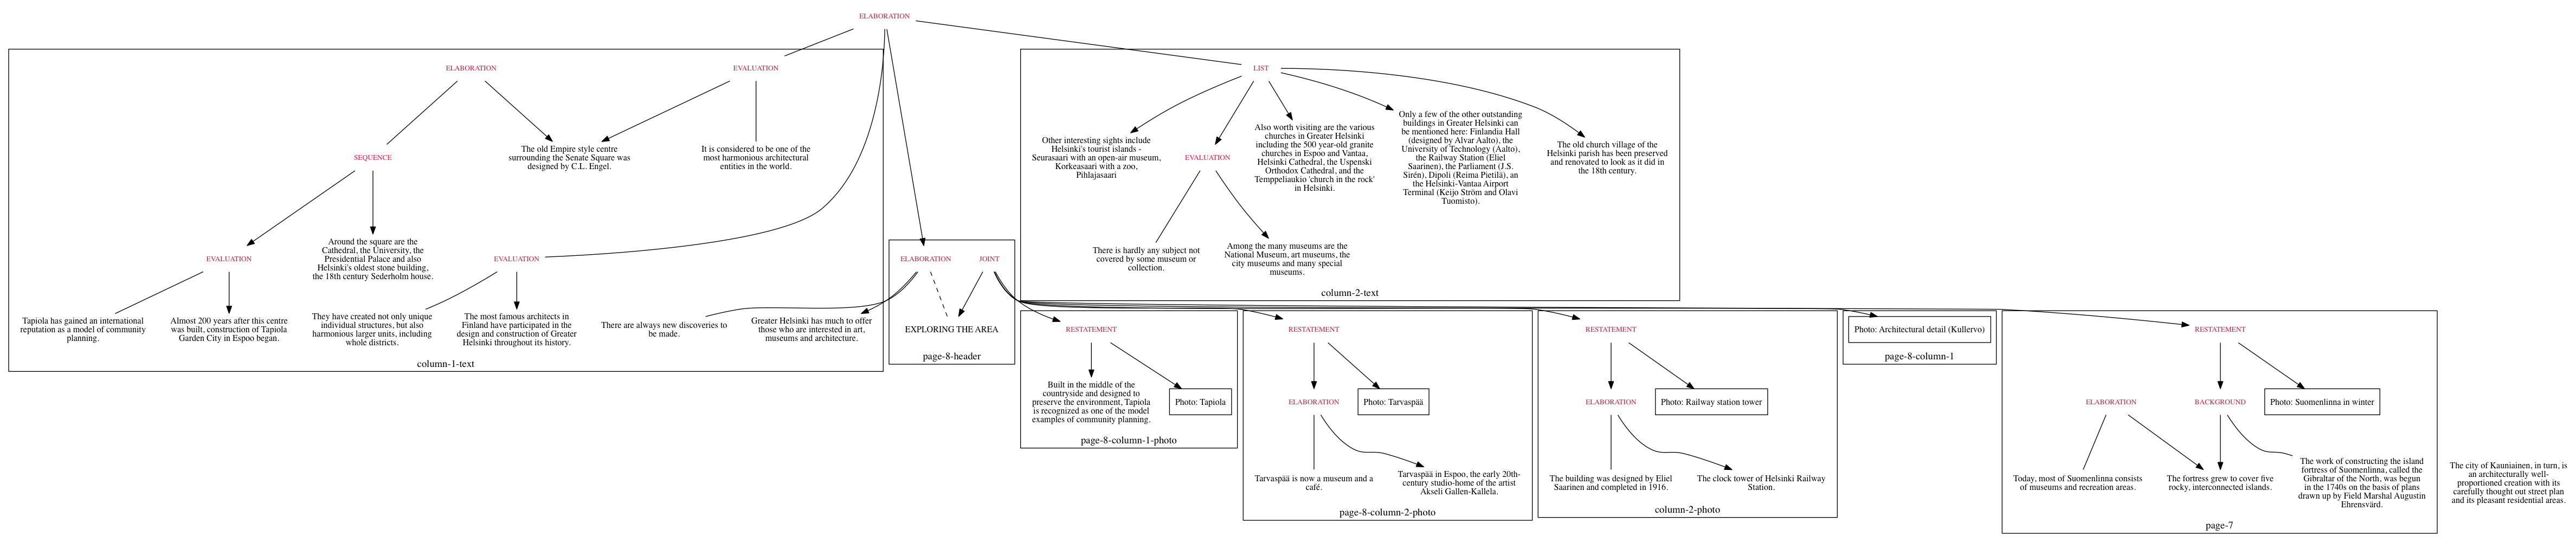

In [10]:
Image('rst_layout_graph.png')